In [1]:
#%%
import numpy as np
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import numba as nb
import sys
import os
import scipy.stats as sts



sys.path.insert(0, os.path.realpath('./transport/'))

from transport import tallies
from transport import material_definitions
from transport import functions_for_transport

from transport import functions_for_scattering_theory as xs

In [2]:
%matplotlib widget

In [3]:
0.3*1000/60

5.0

In [49]:

N = 1.5e2
gen = 500
iE = 200
print(f'Particle Histories: {N}')
print(f'Energy Bins: {iE}')

Emin = 1e-5
Emax = 2e7 
iEbins = 200
tally = tallies.tallies(Emin, Emax, iEbins)

Sig_g = 1.4; dSig_g = 0.2
Sig_f = 1.0; dSig_f =  0.2
nubar = 2.4; dnubar =  0.2
Sig_s = 1.0; dSig_s =  0.5

mat = material_definitions.material_MG(nubar, Sig_f, Sig_g, Sig_s)

# # option to set seed
rng = np.random.default_rng()
tally = functions_for_transport.transport_loop_0D_MG(N, gen, tally, mat, rng)

final_k_estimate, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 
print(final_k_estimate, final_estimator_variance)
print(f'Analytic: {nubar*Sig_f/(Sig_g+Sig_f)}')

Particle Histories: 150.0
Energy Bins: 200
1.0007206666666666 0.0010102395261141516
Analytic: 1.0


In [48]:
mc_samples = 1000000

keff1 = []
for imc in range(mc_samples):

    # reset tally object
    # tally = tallies.tallies(Emin, Emax, iEbins)

    # sample nuclear data
    nu = np.random.default_rng().normal(loc=nubar, scale=dnubar)
    f = np.random.default_rng().normal(loc=Sig_f, scale=dSig_f)
    g = np.random.default_rng().normal(loc=Sig_g, scale=dSig_g)
    s = np.random.default_rng().normal(loc=Sig_s, scale=dSig_s)
    # nu = np.random.normal(nubar, dnubar)
    # f = np.random.normal(Sig_f, dSig_f)
    # g = np.random.normal(Sig_g, dSig_g)
    # s = np.random.normal(Sig_s, dSig_s)


    # # run transport
    # mat = material_definitions.material_MG(nu, f, g, s)
    # # print(mat.nubar)
    # rng = np.random.default_rng()
    # tally = functions_for_transport.transport_loop_0D_MG(N, gen, tally, mat, rng)
    # final_k, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 
    final_k = nu*f/(g+f)

    # store keff estimate
    keff1.append(final_k)

print(np.mean(keff1))
print(np.std(keff1))

0.9972681836362697
0.16879251322095717


1.4389666666666665


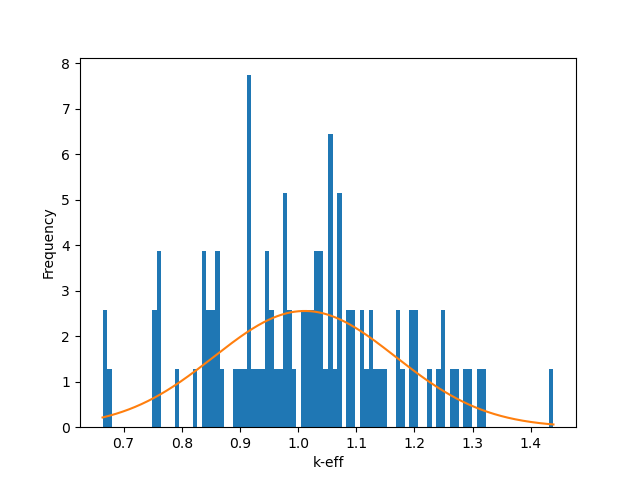

In [10]:

figure()
bins = hist(keff1, bins=100, density=True, label='k-eff Samples')
x = np.linspace(min(keff1), max(keff1), 1000)
plot(x, sts.norm.pdf(x, loc=np.mean(keff1), scale=np.std(keff1)), label='Fitted Normal')
xlabel('k-eff')
ylabel('Frequency')
print(max(keff1))

In [11]:
dnubar

0.2

In [43]:
# First order linear propagation


N = 1.5e2
gen = 100

# vals = [nubar, Sig_f, Sig_g, Sig_s]
# std = [dnubar, dSig_f, dSig_g, dSig_s] 
vals = [Sig_f, Sig_s, Sig_g, nubar]
std = [dSig_f, dSig_s, dSig_g, dnubar] 

k = np.zeros((len(vals), 2))
dat = np.zeros((len(vals), 2))

for inudat, nudat in enumerate(vals):

    # plus
    tempvals = vals.copy()
    dat_plus = nudat + std[inudat]/2
    tempvals[inudat] = dat_plus
    # print(tempvals)
    tally = tallies.tallies(Emin, Emax, iEbins)
    # nu, f, g, s = tempvals
    f, s, g, nu = tempvals

    mat = material_definitions.material_MG(nu, f, g, s)
    rng = np.random.default_rng()
    tally = functions_for_transport.transport_loop_0D_MG(N, gen, tally, mat, rng)
    k_plus, _, _ = tally.final_analysis() 
    # k_plus = nu*f/(g+f)

    # minus
    tempvals = vals.copy()
    dat_minus = nudat - std[inudat]/2
    tempvals[inudat] = dat_minus

    tally = tallies.tallies(Emin, Emax, iEbins)
    # nu, f, g, s = tempvals
    f, s, g, nu = tempvals

    mat = material_definitions.material_MG(nu, f, g, s)
    rng = np.random.default_rng()
    tally = functions_for_transport.transport_loop_0D_MG(N, gen, tally, mat, rng)
    k_minus, _, _ = tally.final_analysis() 
    # k_minus = nu*f/(g+f)

    k[inudat, :] = np.array([k_plus, k_minus])
    dat[inudat, :] = np.array([dat_plus, dat_minus])


dk_ddat = (np.diff(k, axis=1)/np.diff(dat, axis=1)).flatten()
print(dk_ddat)
stddat = np.array(std)
dk_analytic = np.sqrt(np.sum((dk_ddat*stddat)**2))
print(dk_analytic)

[ 0.633  0.02  -0.536  0.347]
0.18009930593980641


In [44]:
print(3.36/(1+1.4)**2) #dkdf
print(-2.4/(1.4+1)**2) # dkdg
print(1/(1+1.4))

0.5833333333333334
-0.4166666666666667
0.4166666666666667


In [46]:
dk_ddat = np.array([0.5833333333333334, 0, -0.4166666666666667, 0.4166666666666667])
dk_analytic = np.sqrt(np.sum((dk_ddat*stddat)**2))
print(dk_analytic)

0.16583123951777


In [24]:
import numpy.linalg as la

## Bayesian update
prior_dat = np.array([vals]).T
prior_cov = np.diag(stddat**2)

Pbar = prior_dat
M = prior_cov

D = np.array([[1.2]]).T
V = np.matrix([[0.01**2]])

Tbar = final_k_estimate
G = np.matrix(dk_ddat)


# sammy manual
Mp = la.inv(la.inv(M) + G.T @ la.inv(V) @ G)
Pbarp = Pbar + Mp @ G.T @ la.inv(V) @ (D-Tbar)

print(Mp)
print()
print(Pbar.flatten())
print(np.sqrt(np.diag(M)))
print()
print(Pbarp.flatten())
print(np.sqrt(np.diag(Mp)))

[[ 2.11950688e-02  3.81708650e-06  1.40026001e-02 -1.41358710e-02]
 [ 3.81708650e-06  2.49999999e-01 -2.84229362e-06  2.86934537e-06]
 [ 1.40026001e-02 -2.84229362e-06  2.95733301e-02  1.05259066e-02]
 [-1.41358710e-02  2.86934537e-06  1.05259066e-02  2.93739123e-02]]

[1.  1.  1.4 2.4]
[0.2 0.5 0.2 0.2]

[[1.15764567 0.999968   1.28261327 2.51850396]]
[0.14558526 0.5        0.17196898 0.17138819]


In [33]:
stdevs = np.atleast_2d(np.sqrt(np.diag(Mp)))
corr = Mp / (stdevs.T @ stdevs)
print(corr)

[[ 1.00000000e+00  5.24378145e-05  5.59295282e-01 -5.66531758e-01]
 [ 5.24378145e-05  1.00000000e+00 -3.30558875e-05  3.34835831e-05]
 [ 5.59295282e-01 -3.30558875e-05  1.00000000e+00  3.57131780e-01]
 [-5.66531758e-01  3.34835831e-05  3.57131780e-01  1.00000000e+00]]


In [38]:
mc_samples = 5000
N = 1.5e2
gen = 200


keff = []
for imc in range(mc_samples):

    sample = np.random.default_rng().multivariate_normal(np.array(Pbarp).flatten(), Mp)
    f, s, g, nu = sample
    # # run transport
    tally = tallies.tallies(Emin, Emax, iEbins)
    mat = material_definitions.material_MG(nu, f, g, s)
    # print(mat.nubar)
    rng = np.random.default_rng()
    tally = functions_for_transport.transport_loop_0D_MG(N, gen, tally, mat, rng)
    final_k, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 
    # final_k = nu*f/(g+f)

    # store keff estimate
    keff.append(final_k)

print(np.mean(keff))
print(np.std(keff))

1.1872865466666667
0.03337697502948602


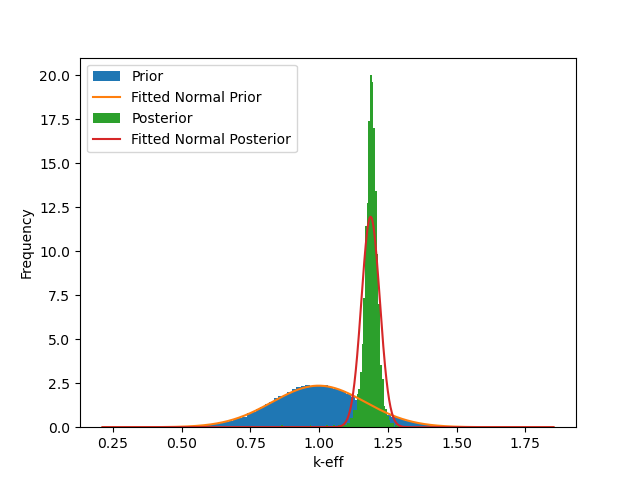

In [39]:
x = np.linspace(min(keff1), max(keff1), 1000)
figure()
bins = hist(keff1, label='Prior', bins=100, density=True)
plot(x, sts.norm.pdf(x, loc=np.mean(keff1), scale=np.std(keff1)), label='Fitted Normal Prior')

bins = hist(keff, label='Posterior', bins=100, density=True)
plot(x, sts.norm.pdf(x, loc=np.mean(keff), scale=np.std(keff)), label='Fitted Normal Posterior')

xlabel('k-eff')
ylabel('Frequency')
legend()